### Universal Recognition with Qwen2.5-VL

This notebook demonstrates how to use Qwen2.5-VL for universal recognition. It takes an image and a query, and then uses the model to interpret the user's query on the image.

!pip install git+https://github.com/huggingface/transformers
!pip install qwen-vl-utils
!pip install qwen_agent
!pip install openai#### \[Setup\]

Load plotting and inference util.

In [ ]:
!pip install git+https://github.com/huggingface/transformers
!pip install qwen-vl-utils
!pip install openai

Looking in indexes: https://mirrors.aliyun.com/pypi/simple
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-a_chqzh7
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-a_chqzh7
^C
ERROR: Operation cancelled by user

[notice] A new release of pip is available: 23.3.2 -> 25.0
[notice] To update, run: pip install --upgrade pip
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [1]:
import json
import random
from PIL import Image, ImageDraw, ImageFont
from openai import OpenAI
import os
import base64


# @title inference function
def inference(image_path, prompt, sys_prompt="You are a helpful assistant.", max_new_tokens=4096, return_input=False):
    image = Image.open(image_path)
    image_local_path = "file://" + image_path
    messages = [
        {"role": "system", "content": sys_prompt},
        {"role": "user", "content": [
                {"type": "text", "text": prompt},
                {"image": image_local_path},
            ]
        },
    ]
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    print("text:", text)
    # image_inputs, video_inputs = process_vision_info([messages])
    inputs = processor(text=[text], images=[image], padding=True, return_tensors="pt")
    inputs = inputs.to('cuda')

    output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    if return_input:
        return output_text[0], inputs
    else:
        return output_text[0]
    
    



#  base 64 编码格式
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


# @title inference function with API
def inference_with_api(image_path, prompt, sys_prompt="You are a helpful assistant.", model_id="qwen2.5-vl-72b-instruct", min_pixels=512*28*28, max_pixels=2048*28*28):
    base64_image = encode_image(image_path)
    client = OpenAI(
        #If the environment variable is not configured, please replace the following line with the Dashscope API Key: api_key="sk-xxx". Access via https://bailian.console.alibabacloud.com/?apiKey=1 "
        api_key=os.getenv('DASHSCOPE_API_KEY'),
        base_url="https://dashscope-intl.aliyuncs.com/compatible-mode/v1",
    )


    messages=[
        {
            "role": "system",
            "content": [{"type":"text","text": sys_prompt}]},
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "min_pixels": min_pixels,
                    "max_pixels": max_pixels,
                    # Pass in BASE64 image data. Note that the image format (i.e., image/{format}) must match the Content Type in the list of supported images. "f" is the method for string formatting.
                    # PNG image:  f"data:image/png;base64,{base64_image}"
                    # JPEG image: f"data:image/jpeg;base64,{base64_image}"
                    # WEBP image: f"data:image/webp;base64,{base64_image}"
                    "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                },
                {"type": "text", "text": prompt},
            ],
        }
    ]
    completion = client.chat.completions.create(
        model = model_id,
        messages = messages,
       
    )
    return completion.choices[0].message.content

Load model and processors.

In [2]:
import torch
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
model_path = "Qwen/Qwen2.5-VL-7B-Instruct"
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(model_path, torch_dtype=torch.bfloat16, attn_implementation="flash_attention_2",device_map="auto")
processor = AutoProcessor.from_pretrained(model_path)

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-29 20:40:21.602488: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-29 20:40:21.605259: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-29 20:40:21.640557: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-29 20:40:21.640584: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cu



#### 1. Birds Recognition

There are more than 10,000 bird species in the world, and many of them have only slight differences in appearance. This is a very challenging fine-grained recognition task.

##### 1.1 Single image recognition 

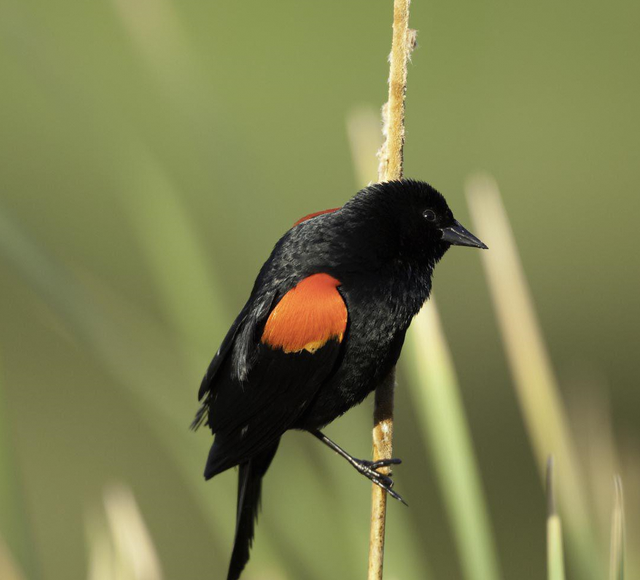

text: <|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
What kind of bird is this? Please give its name in Chinese and English.<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant

This bird is a Red-winged Blackbird (Agelaius phoeniceus). In Chinese, it is called "红翅黑鹂" (hóng wì hēi lí).


In [4]:
image_path = "assets/universal_recognition/unireco_bird_example.jpg"
prompt = "What kind of bird is this? Please give its name in Chinese and English."

image = Image.open(image_path)
image.thumbnail([640,640], Image.Resampling.LANCZOS)
display(image)

## Use a local HuggingFace model to inference.
response = inference(image_path, prompt)
print(response)

## Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here'
# response = inference_with_api(image_path, prompt)
# print(response)

##### 1.2 Multi images recognition 

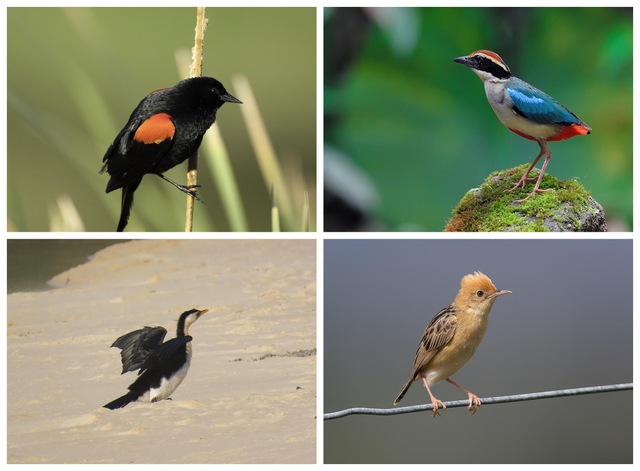

text: <|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
What are these birds? Please give their names in English and Chinese.<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant

The birds in the images are as follows:

1. **Top left**: This bird is a Red-winged Blackbird (Agelaius phoeniceus). In Chinese, it is called "红翅黑鹂" (hóng wì hēi lí).

2. **Top right**: This bird is a Blue-winged Pitta (Pitta brachyura). In Chinese, it is called "蓝翅八色鸫" (lán wì bā sè dōng).

3. **Bottom left**: This bird is a Little Pied Cormorant (Microcarbo melanoleucos). In Chinese, it is called "小斑鸬鹚" (xiǎo bān lú cí).

4. **Bottom right**: This bird is a Cinnamon-headed Bunting (Emberiza tahapisi). In Chinese, it is called "棕顶雀鹀" (zōng dǐng què wū).


In [12]:
image_path = "./assets/universal_recognition/unireco_birds_example.jpg"
prompt = "What are these birds? Please give their names in English and Chinese."

image = Image.open(image_path)
image.thumbnail([640,640], Image.Resampling.LANCZOS)
display(image)

## Use a local HuggingFace model to inference.
response = inference(image_path, prompt)
print(response)

## Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here'
# response = inference_with_api(image_path, prompt)
# print(response)


Or you can try other challenging categories like landmark recognition, celebrity recognition, etc.

#### 2. Landmarks Recognition

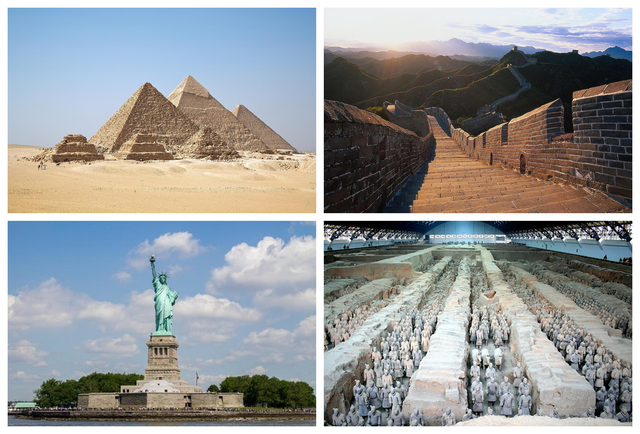

text: <|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
What are these attractions? Please give their names in English and Chinese.<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant

The images you've provided showcase four of the most iconic landmarks from around the world:

1. **Pyramids of Giza** (埃及金字塔)
   - **English:** Pyramids of Giza
   - **Chinese:** 埃及金字塔

2. **Great Wall of China** (中国长城)
   - **English:** Great Wall of China
   - **Chinese:** 中国长城

3. **Statue of Liberty** (自由女神像)
   - **English:** Statue of Liberty
   - **Chinese:** 自由女神像

4. **Terracotta Army** (兵马俑)
   - **English:** Terracotta Army
   - **Chinese:** 兵马俑


In [11]:
image_path = "./assets/universal_recognition/unireco_landmarks_example.jpg"
prompt = "What are these attractions? Please give their names in English and Chinese."

image = Image.open(image_path)
image.thumbnail([640,640], Image.Resampling.LANCZOS)
display(image)

## Use a local HuggingFace model to inference.
response = inference(image_path, prompt)
print(response)

## Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here'
# response = inference_with_api(image_path, prompt)
# print(response)

#### 3. Celebrities Recognition

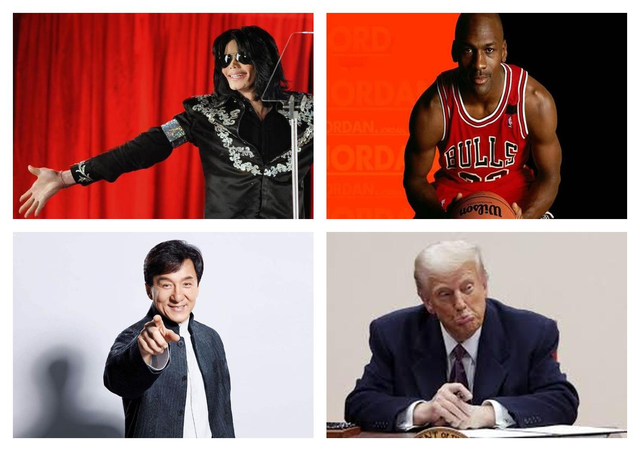

text: <|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
Who are these in this picture? Please give their names in English and Chinese.<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant

The individuals in the picture are:

1. Michael Jackson (迈克尔·杰克逊)
2. Michael Jordan (迈克尔·乔丹)
3. Jackie Chan (成龙)
4. Donald Trump (唐纳德·特朗普)


In [13]:
image_path = "./assets/universal_recognition/unireco_celebrities_example.jpg"
prompt = "Who are these in this picture? Please give their names in English and Chinese."

image = Image.open(image_path)
image.thumbnail([640,640], Image.Resampling.LANCZOS)
display(image)

## Use a local HuggingFace model to inference.
response = inference(image_path, prompt)
print(response)

## Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here'
# response = inference_with_api(image_path, prompt)
# print(response)